In [ ]:
!pip install scikit-learn-extra

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import arff
from sklearn.cluster import k_means, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples, pairwise_distances
from sklearn_extra.cluster import KMedoids

# 1. Importation des données

In [2]:
data = arff.loadarff('Dataset/PhishingData.arff')
df = pd.DataFrame(data[0])
df.drop(columns=['Result'], inplace=True)
df.describe()

,SFH,popUpWidnow,SSLfinal_State,Request_URL,URL_of_Anchor,web_traffic,URL_Length,age_of_domain,having_IP_Address
count,1353,1353,1353,1353,1353,1353,1353,1353,1353
unique,3,3,3,3,3,3,3,2,2
top,b'1',b'0',b'1',b'-1',b'-1',b'0',b'0',b'1',b'0'
freq,767,639,751,617,610,473,563,825,1198


In [44]:
def plot_elbow_and_silhouette_curves(elbow_values=None, silhouette_scores=None, start_n_clusters=1):
    if elbow_values==None and silhouette_scores==None:
        raise Exception("Neither elbow_values nor silhouette_scores is present")
    tmp = (elbow_values != None) + (silhouette_scores!=None)
    fig, ax = plt.subplots(tmp, 1, figsize=(20, 4*tmp))
    if elbow_values!=None:
        ax[0].set_ylabel('Variance Intraclasses')
        ax[0].set_xlabel('Nombre de cluster')
        ax[0].set_xticks(np.arange(start_n_clusters, len(elbow_values)+start_n_clusters))
        ax[0].plot(np.arange(start_n_clusters, len(elbow_values)+start_n_clusters), elbow_values, 'go-', linewidth=2, markersize=5)
    if silhouette_scores!=None:
        ax = ax[tmp-1] if tmp == 2 else ax
        ax.set_ylabel('Silhouette')
        ax.set_xlabel('Nombre de cluster')
        ax.set_xticks(np.arange(start_n_clusters, len(silhouette_scores)+start_n_clusters))
        ax.plot(np.arange(start_n_clusters, len(silhouette_scores)+start_n_clusters), silhouette_scores, 'go-', linewidth=2, markersize=5)
    fig.tight_layout()
    plt.show()

In [4]:
def hamming_distance(x1, x2):
    return np.sum(x1 != x2)

In [5]:
%%time
D_matrix = pairwise_distances(df, metric = hamming_distance)

CPU times: user 11.4 s, sys: 10.4 ms, total: 11.4 s
Wall time: 11.4 s


# 2. PAM Clustering

In [6]:
%%time
k_medoids_elbow_values = []
k_medoids_silhouette_scores = []
for i in np.arange(2, 15):
    kmedoids = KMedoids(n_clusters=i, init='build', method='pam', metric='precomputed').fit(D_matrix)
    k_medoids_silhouette_scores.append(silhouette_score(D_matrix, kmedoids.labels_, metric='precomputed') if i>1 else 0)
    k_medoids_elbow_values.append(kmedoids.inertia_)

CPU times: user 10.8 s, sys: 23.7 ms, total: 10.9 s
Wall time: 10.9 s


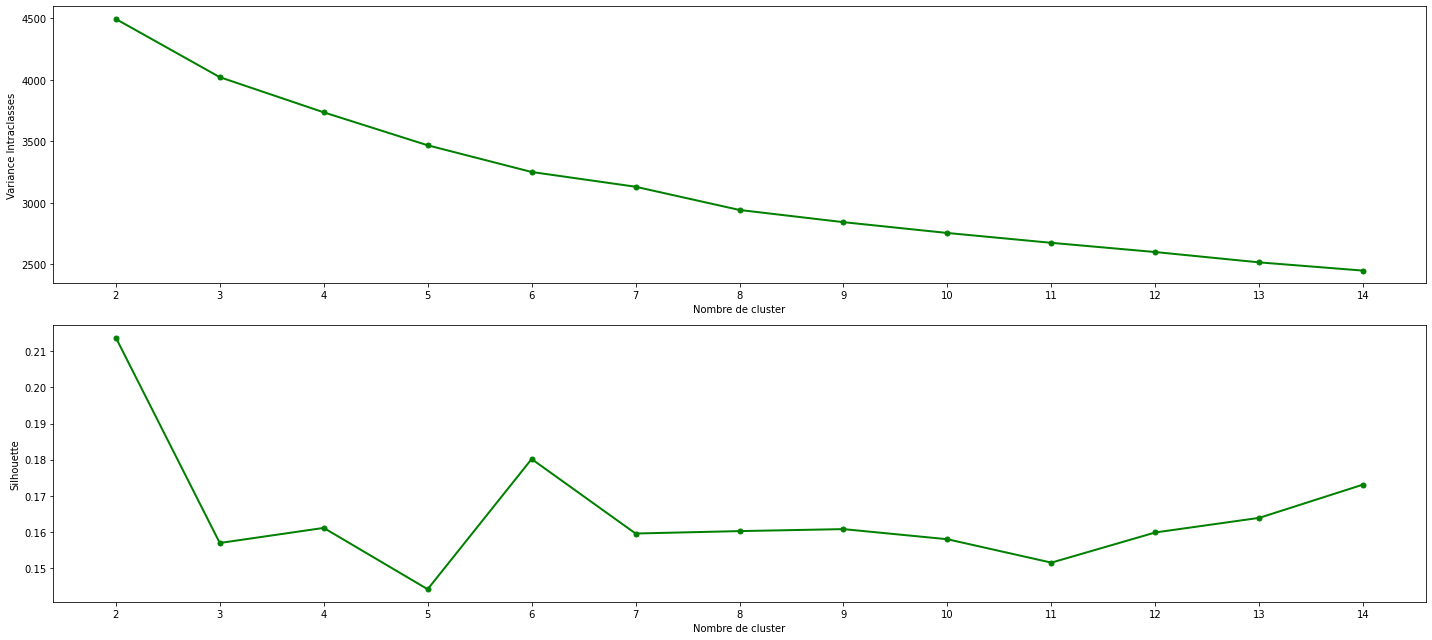

In [41]:
plot_elbow_and_silhouette_curves(k_medoids_elbow_values, k_medoids_silhouette_scores, 2)

In [10]:
n_clusters = 2
kmedoids = KMedoids(n_clusters=n_clusters, init='build', method='pam', metric='precomputed').fit(D_matrix)
sample_silhouette_values = silhouette_samples(D_matrix, kmedoids.labels_, metric='precomputed')

In [24]:
df.iloc[kmedoids.medoid_indices_]

,SFH,popUpWidnow,SSLfinal_State,Request_URL,URL_of_Anchor,web_traffic,URL_Length,age_of_domain,having_IP_Address
322,b'1',b'0',b'1',b'-1',b'1',b'-1',b'0',b'1',b'0'
994,b'-1',b'-1',b'-1',b'-1',b'-1',b'1',b'-1',b'-1',b'0'


## Graphe silhouette pour k = 2

[]

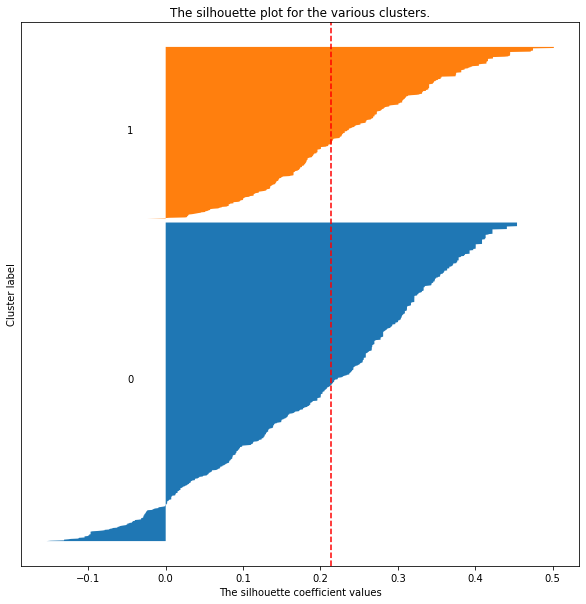

In [66]:
fig, ax = plt.subplots(figsize=(10, 10))
y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[kmedoids.labels_ == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    ax.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values
    )

    # Label the silhouette plots with their cluster numbers at the middle
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax.set_title("The silhouette plot for the various clusters.")
ax.set_xlabel("The silhouette coefficient values")
ax.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax.axvline(x=silhouette_score(D_matrix, kmedoids.labels_, metric='precomputed'), color="red", linestyle="--")

ax.set_yticks([])  # Clear the yaxis labels / ticks

# 3. CAH Clustering

In [29]:
%%time
cah_elbow_values = []
cah_silhouette_scores = []
for i in np.arange(1, 15):
    cah = AgglomerativeClustering(n_clusters=i, affinity='precomputed', linkage='single').fit(D_matrix)
    cah_silhouette_scores.append(silhouette_score(D_matrix, cah.labels_, metric='precomputed') if i>1 else 0)
    cah_elbow_values.append(0)

CPU times: user 603 ms, sys: 3.88 ms, total: 607 ms
Wall time: 741 ms


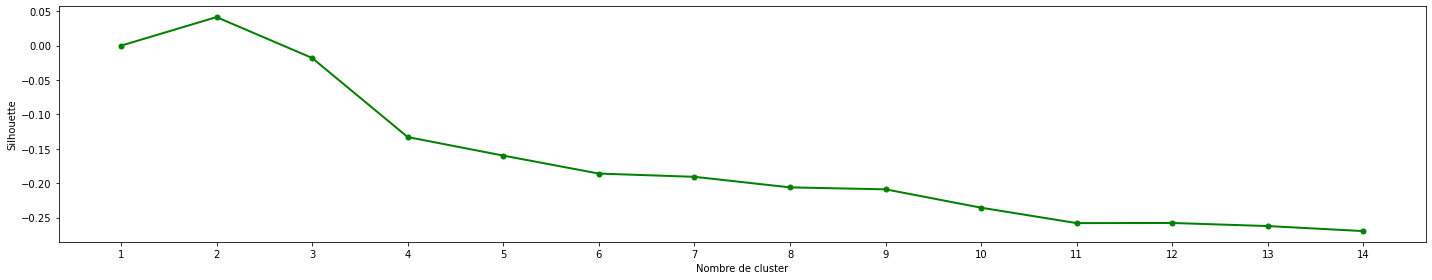

In [45]:
plot_elbow_and_silhouette_curves(silhouette_scores=cah_silhouette_scores)